In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.4.0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.3.3
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.0
tensorflow 2.4.0
tensorflow.keras 2.4.0


In [2]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.experimental.list_logical_devices('GPU')

print(tf.test.is_gpu_available())
print(len(gpus))
print(len(logical_gpus))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
1
1


In [3]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = '../datasets/cifar-10/trainLabels.csv'
test_csv_file = '../datasets/cifar-10/sampleSubmission.csv'
train_folder = '../datasets/cifar-10/train/'
test_folder = '../datasets/cifar-10/test'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('../datasets/cifar-10/train/1.png', 'frog'),
 ('../datasets/cifar-10/train/2.png', 'truck'),
 ('../datasets/cifar-10/train/3.png', 'truck'),
 ('../datasets/cifar-10/train/4.png', 'deer'),
 ('../datasets/cifar-10/train/5.png', 'automobile')]
[('../datasets/cifar-10/test\\1.png', 'cat'),
 ('../datasets/cifar-10/test\\2.png', 'cat'),
 ('../datasets/cifar-10/test\\3.png', 'cat'),
 ('../datasets/cifar-10/test\\4.png', 'cat'),
 ('../datasets/cifar-10/test\\5.png', 'cat')]
50000 300000


In [4]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                           filepath       class
0  ../datasets/cifar-10/train/1.png        frog
1  ../datasets/cifar-10/train/2.png       truck
2  ../datasets/cifar-10/train/3.png       truck
3  ../datasets/cifar-10/train/4.png        deer
4  ../datasets/cifar-10/train/5.png  automobile
                               filepath       class
0  ../datasets/cifar-10/train/45001.png       horse
1  ../datasets/cifar-10/train/45002.png  automobile
2  ../datasets/cifar-10/train/45003.png        deer
3  ../datasets/cifar-10/train/45004.png  automobile
4  ../datasets/cifar-10/train/45005.png    airplane
                          filepath class
0  ../datasets/cifar-10/test\1.png   cat
1  ../datasets/cifar-10/test\2.png   cat
2  ../datasets/cifar-10/test\3.png   cat
3  ../datasets/cifar-10/test\4.png   cat
4  ../datasets/cifar-10/test\5.png   cat


In [5]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

# Flow from dataframe, not directory
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [6]:
for i in range(1):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]


## Modeling

In [7]:
# Image size is small, enlarge the filters
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding="same",
                        activation="selu", input_shape=[width, height, channels]),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding="same",
                        activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding="same",
                        activation="selu"),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding="same",
                        activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",
                        activation="selu"),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding="same",
                        activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.Dense(num_classes, activation="softmax"),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost

In [ ]:
epochs = 20  # raise this!
# fit fit_generator?
history = model.fit_generator(train_generator, 
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

c:\users\a\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHa

In [9]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


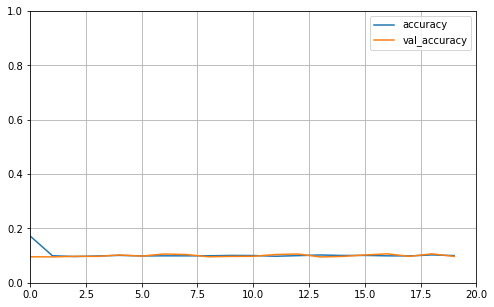

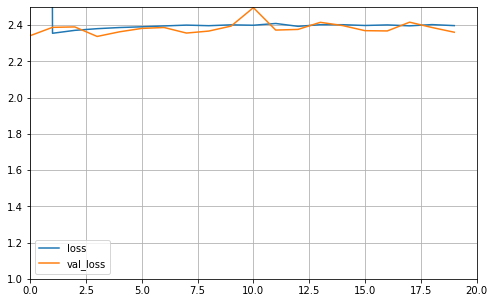

In [10]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 1, 2.5)

In [12]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [ ]:
test_predict = model.predict_generator(test_generator,
                                       workers = 10,
                                       use_multiprocessing = True)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

c:\users\a\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Executing op __inference_predict_function_64400 in device /job:localhost/replica:0/task:0/device:GPU:0


Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\users\a\appdata\local\programs\python\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\a\appdata\local\programs\python\python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\a\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 748, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\users\a\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 727, in pool_fn
    initargs=(seqs, None, get_worker_id_queue()))
  File "c:\users\a\appdata\local\programs\python\python36\lib\multiprocessing\context.py", line 119, in Pool
    context=self.get_context())
  File "c:\users\a\appdata\local\programs\python\python36\lib\multiprocessing\pool.py", line 175, in __init__
    self._repopulate_p

In [ ]:
print(test_predict.shape)

In [ ]:
print(test_predict[0:5])

In [ ]:
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [ ]:
print(test_predict_class_indices[0:5])

In [ ]:
test_predict_class = [class_names[index] for index in test_predict_class_indices]

In [ ]:
print(test_predict_class[0:5])

In [ ]:
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "./cifar10/submission.csv"
generate_submissions(output_file, test_predict_class)